In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

SEED = 12345678

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import FactorAnalyzer

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import * 
from imblearn.under_sampling import * 
from imblearn.combine import *

import warnings
warnings.filterwarnings('ignore')

In [5]:
%run a.ipynb

In [48]:
def dataPrep(train):
    train = train.drop(['custid'], axis=1)
    train = train.fillna(0)

    train['총구매액'] = abs(train['총구매액'])
    train['totalBuyPrice'] = abs(train['평균구매가격'])
    train['meanBuyPrice'] = train['totalBuyPrice'] / (train['구매건수'] + 1)

    train['brandNumRatio']   = train['구매브랜드종류'] / np.log(train['구매건수'] + 1)
    train['meanBuyNum']      = train['구매건수'] / (train['내점일수'] + 1)
    train['meanBuyWhenCome'] = train['totalBuyPrice'] / (train['내점일수'] + 1)

    train['spring']    = np.log(train['봄_구매건수']   / train['구매건수'] * train['총구매액'] + 1)
    train['summer']    = np.log(train['여름_구매건수'] / train['구매건수'] * train['총구매액'] + 1)
    train['fall']      = np.log(train['가을_구매건수'] / train['구매건수'] * train['총구매액'] + 1)
    train['winter']    = np.log(train['겨울_구매건수'] / train['구매건수'] * train['총구매액'] + 1)
    train['morning']   = np.log(train['아침_구매건수'] / train['구매건수'] * train['총구매액'] + 1)
    train['night']     = np.log(train['저녁_구매건수'] / train['구매건수'] * train['총구매액'] + 1)
    train['lunch']    = np.log(train['점심_구매건수'] / train['구매건수'] * train['총구매액'] + 1)
    train['log_totalBuyPrice'] = np.log(train['totalBuyPrice'])
    train['log_meanBuyPrice'] = np.log(train['meanBuyPrice'])
    return train
train = pd.read_csv('data/train.csv',encoding='euc-kr')
train = dataPrep(train)
train.replace(train.groupby('주구매코너').mean()['morning'].to_dict(), inplace=True)
train = train.rename(columns={'주구매코너' : 'MostCorner',
              '주말방문비율'  : 'WeekendEnter',
              '평균할부개월수': 'meanInstallment',
              '수입상품_구매비율' : 'Import_Ratio'})

In [49]:
train.columns

Index(['gender', '총구매액', '구매건수', '평균구매가격', 'meanInstallment', '구매브랜드종류',
       '내점일수', 'Import_Ratio', 'WeekendEnter', '가을_구매건수', '겨울_구매건수', '봄_구매건수',
       '여름_구매건수', '아침_구매건수', '저녁_구매건수', '점심_구매건수', 'MostCorner',
       'totalBuyPrice', 'meanBuyPrice', 'brandNumRatio', 'meanBuyNum',
       'meanBuyWhenCome', 'spring', 'summer', 'fall', 'winter', 'morning',
       'night', 'lunch', 'log_totalBuyPrice', 'log_meanBuyPrice'],
      dtype='object')

In [50]:
corrCol = ['gender','meanInstallment', 'Import_Ratio', 'WeekendEnter', 'meanBuyNum',
              'MostCorner', 'totalBuyPrice', 'meanBuyPrice', 'brandNumRatio',
              'meanBuyWhenCome', 'spring', 'summer', 'fall', 'winter', 'morning',
              'night', 'lunch', 'log_totalBuyPrice', 'log_meanBuyPrice']
train[corrCol].corr().style.background_gradient(cmap='coolwarm')

,gender,meanInstallment,Import_Ratio,WeekendEnter,meanBuyNum,MostCorner,totalBuyPrice,meanBuyPrice,brandNumRatio,meanBuyWhenCome,spring,summer,fall,winter,morning,night,lunch,log_totalBuyPrice,log_meanBuyPrice
gender,1.000000,-0.020066,-0.021294,0.020457,0.067326,0.085880,0.072046,0.002274,0.074438,0.005823,0.053604,0.072637,0.069100,0.048844,0.116875,-0.020075,0.064328,0.080438,-0.028104
meanInstallment,-0.020066,1.000000,0.097727,-0.001625,0.067619,-0.106920,0.407768,0.285082,0.008874,0.322228,0.015074,-0.009002,0.014789,0.008236,0.015415,0.012953,0.044700,0.433075,0.249872
Import_Ratio,-0.021294,0.097727,1.000000,0.016123,-0.233448,-0.252000,0.189546,0.317168,-0.250083,0.315221,-0.212034,-0.220861,-0.246176,-0.215390,-0.200107,-0.209155,-0.255009,0.152112,0.385713
WeekendEnter,0.020457,-0.001625,0.016123,1.000000,-0.020073,-0.116292,0.036351,0.061099,-0.065828,0.071946,-0.091705,-0.062283,-0.047286,-0.013335,-0.139333,0.051646,-0.036487,0.047974,0.121723
meanBuyNum,0.067326,0.067619,-0.233448,-0.020073,1.000000,0.237279,0.031881,-0.375186,0.595258,-0.270792,0.316593,0.337391,0.365155,0.291217,0.320084,0.289398,0.462509,0.076904,-0.517977
MostCorner,0.085880,-0.106920,-0.252000,-0.116292,0.237279,1.000000,-0.085060,-0.215775,0.220553,-0.220048,0.211920,0.240995,0.197263,0.202844,0.267607,0.108594,0.223822,-0.119534,-0.399886
totalBuyPrice,0.072046,0.407768,0.189546,0.036351,0.031881,-0.085060,1.000000,0.546973,0.027114,0.624429,0.073352,0.010846,0.042482,0.051890,0.038823,0.020490,0.163157,0.877816,0.507797
meanBuyPrice,0.002274,0.285082,0.317168,0.061099,-0.375186,-0.215775,0.546973,1.000000,-0.353696,0.957316,-0.274985,-0.323626,-0.355644,-0.300990,-0.273571,-0.274648,-0.356449,0.416148,0.656108
brandNumRatio,0.074438,0.008874,-0.250083,-0.065828,0.595258,0.220553,0.027114,-0.353696,1.000000,-0.358188,0.458523,0.473101,0.496523,0.475007,0.460284,0.404314,0.516290,0.104069,-0.645360
meanBuyWhenCome,0.005823,0.322228,0.315221,0.071946,-0.270792,-0.220048,0.624429,0.957316,-0.358188,1.000000,-0.283783,-0.335248,-0.358728,-0.314570,-0.286147,-0.278877,-0.308146,0.489557,0.691458


In [51]:
# Split Train Test Data with preprocessing
xCol = ['meanInstallment', 'Import_Ratio', 'WeekendEnter', 'meanBuyNum',
              'MostCorner', 'totalBuyPrice', 'meanBuyPrice', 'brandNumRatio',
              'meanBuyWhenCome', 'spring', 'summer', 'fall', 'winter', 'morning',
              'night', 'lunch', 'log_totalBuyPrice', 'log_meanBuyPrice']
X_train, X_test, y_train, y_test, scalerFunc = TrainTestSplit(train, xCol, scalerFunc=RobustScaler)

In [52]:
X_train.shape, X_test.shape

((3500, 18), (1500, 18))

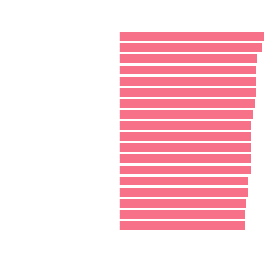

1 morning
2 WeekendEnter
3 lunch
4 brandNumRatio
5 meanInstallment
6 meanBuyNum
7 Import_Ratio
8 totalBuyPrice
9 log_totalBuyPrice
10 meanBuyWhenCome
11 night
12 spring
13 MostCorner
14 log_meanBuyPrice
15 meanBuyPrice
16 fall
17 summer
18 winter


In [53]:
Tree_Feature_Importance_Plot(X_train, y_train)

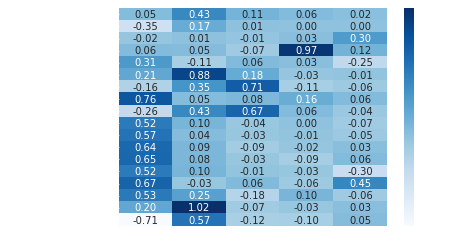

In [54]:
### PCA
def FACTOR_ANALYZER_PLOT(X_train,n_factors = 10):
    trainDF = X_train.copy()
    fa = FactorAnalyzer(n_factors=n_factors).fit(trainDF)

    eigen_values, vectors = fa.get_eigenvalues()
    loadings = fa.loadings_

    factor = pd.DataFrame(loadings.T, columns = trainDF.columns).T

    with plt.rc_context({'axes.edgecolor':'white',
                                'xtick.color':'white',
                                'ytick.color':'white',}):
        sns.heatmap(factor, cmap="Blues", annot=True, fmt='.2f')
        plt.show()
    return factor

def GEN_FACOTR_DIC(factor, factorIndex, factorThreashold):
    factor_dict = {}
    for _idx, _threashold in zip(factorIndex, factorThreashold):
        factor_dict[_idx] = [list( factor[_idx][ abs(factor[_idx]) > _threashold].sort_values(ascending = False).index)]
    #print(factor_dict)
    return factor_dict
    
def PCA_FACTOR(df, factor_dict, num=0, PCA_LIST=None ,n_components = 1):
    if PCA_LIST is None:
        PCA_INIT = True
        PCA_LIST = []
    else:
        PCA_INIT = False
        
    rmCol = []
    for idx, (k, _v) in enumerate(factor_dict.items()):
        v = _v[0]
        #n_components = (len(v) - 1) // 2 + 1
        if PCA_INIT:
            PCA_LIST.append( PCA(n_components=n_components) )
        #print(PCA_LIST[idx].fit_transform(df[v]))
        
        for num_c in range(n_components):
            df[f'PCA_{num}_{k}_{num_c}'] = PCA_LIST[idx].fit_transform(df[v])[:, num_c]
        rmCol.extend(v)
    df = df[ df.columns.difference(rmCol) ]
    
    if PCA_INIT: return df, PCA_LIST
    return df

factor_0 = FACTOR_ANALYZER_PLOT(X_train,5)

In [55]:
factorIndex = [0]
factorThreashold = [0.7]
factor_dict_0 = GEN_FACOTR_DIC(factor_0,factorIndex,factorThreashold)
trainDF_, pcaList_0 = PCA_FACTOR(X_train, factor_dict_0, num=0)
testDF_ = PCA_FACTOR(X_test, factor_dict_0, PCA_LIST=pcaList_0, num=0)

In [56]:
trainDF_.shape, testDF_.shape

((3500, 17), (1500, 17))

In [57]:
trainDF__ = trainDF_.copy()
trainDF__['gender'] = y_train
trainDF__.corr().style.background_gradient(cmap='coolwarm')

,Import_Ratio,MostCorner,PCA_0_0_0,WeekendEnter,fall,log_totalBuyPrice,lunch,meanBuyNum,meanBuyPrice,meanBuyWhenCome,meanInstallment,morning,night,spring,summer,totalBuyPrice,winter,gender
Import_Ratio,1.000000,-0.246351,-0.343025,0.000089,-0.247900,0.154943,-0.212764,-0.221188,0.301046,0.303397,0.111885,-0.205908,-0.208543,-0.205953,-0.218772,0.191944,-0.214056,-0.026182
MostCorner,-0.246351,1.000000,0.341003,-0.112661,0.204294,-0.110634,0.219526,0.246312,-0.220599,-0.220904,-0.111476,0.277075,0.102838,0.231312,0.246739,-0.077784,0.203338,0.089312
PCA_0_0_0,-0.343025,0.341003,1.000000,-0.090811,0.541174,-0.230524,0.511203,0.611719,-0.550304,-0.570755,-0.130637,0.493369,0.431830,0.484322,0.513172,-0.254442,0.505185,0.074849
WeekendEnter,0.000089,-0.112661,-0.090811,1.000000,-0.032005,0.044519,-0.045311,-0.011442,0.039373,0.051071,-0.009704,-0.130233,0.071525,-0.077736,-0.067952,0.030680,0.005396,0.024702
fall,-0.247900,0.204294,0.541174,-0.032005,1.000000,0.080182,0.454109,0.372744,-0.375864,-0.373821,0.008922,0.377415,0.335936,0.276608,0.435506,0.032358,0.369501,0.075230
log_totalBuyPrice,0.154943,-0.110634,-0.230524,0.044519,0.080182,1.000000,0.221689,0.075220,0.415230,0.491087,0.434127,0.076724,0.048655,0.113176,0.048519,0.870362,0.093624,0.074666
lunch,-0.212764,0.219526,0.511203,-0.045311,0.454109,0.221689,1.000000,0.451499,-0.360009,-0.314009,0.025468,0.305988,0.216756,0.410355,0.397552,0.153611,0.423257,0.068070
meanBuyNum,-0.221188,0.246312,0.611719,-0.011442,0.372744,0.075220,0.451499,1.000000,-0.371492,-0.264431,0.057633,0.324751,0.284354,0.316281,0.327109,0.034034,0.281122,0.080065
meanBuyPrice,0.301046,-0.220599,-0.550304,0.039373,-0.375864,0.415230,-0.360009,-0.371492,1.000000,0.956006,0.300614,-0.280297,-0.275325,-0.279116,-0.319646,0.542209,-0.301539,-0.006205
meanBuyWhenCome,0.303397,-0.220904,-0.570755,0.051071,-0.373821,0.491087,-0.314009,-0.264431,0.956006,1.000000,0.330014,-0.289877,-0.277978,-0.286665,-0.330623,0.623878,-0.320941,0.002896


In [58]:
def ImbTest(model, X, Y, X_test, Y_test):
    ImbDic = {
        ### Under Sampling
        'CondensedNearestNeighbour' : CondensedNearestNeighbour,
        'ClusterCentroids' : ClusterCentroids,
        'EditedNearestNeighbours' : EditedNearestNeighbours,
        'RepeatedEditedNearestNeighbours' : RepeatedEditedNearestNeighbours,
        'AllKNN' : AllKNN,
        'InstanceHardnessThreshold' : InstanceHardnessThreshold,
        'NearMiss' : NearMiss,
        'RandomUnderSampler' : RandomUnderSampler,
        'TomekLinks' : TomekLinks,

        ### Over Sampling
        'ADASYN' : ADASYN,
        'BorderlineSMOTE' : BorderlineSMOTE,
        'RandomOverSampler' : RandomOverSampler,
        'SMOTE' : SMOTE,
        'SVMSMOTE' : SVMSMOTE,

        ### Hybrid Sampling
        'SMOTEENN' : SMOTEENN,
        'SMOTETomek' : SMOTETomek,
    }
    res = []
    for sName, sampler in ImbDic.items():
        if sName in ['EditedNearestNeighbours', 'RepeatedEditedNearestNeighbours', 'AllKNN','NearMiss','TomekLinks']:
            X_res, Y_res = sampler().fit_resample(X, Y)
        else:
            X_res, Y_res = sampler(random_state=SEED).fit_resample(X, Y)
        model.fit(X_res, Y_res)
        y_pred = model.predict(X_test)
        acc = accuracy_score(Y_test, y_pred)
        pre = precision_score(Y_test, y_pred)
        rec = recall_score(Y_test, y_pred)
        f1_ = f1_score(Y_test, y_pred)
        res.append([sName, acc, pre, rec, f1_])
    with plt.rc_context({'axes.edgecolor':'white',
                            'xtick.color':'white',
                            'ytick.color':'white',}):
        rNameList = [ x[0] for x in res]
        labelList = ['acc', 'pre', 'recall', 'f1']
        ColorList = ['r', 'b', 'g', 'k']
        for i, label, c in zip(range(len(res) - 1), labelList, ColorList):
            plt.plot(rNameList, [ x[i + 1] for x in res], label=label, color=c)
        plt.xticks(rotation=90)
        plt.plot(rNameList, [ (x[1] + x[-1])/2 for x in res], color='y', linewidth=5.0, label='acc_f1_avg')
        plt.legend()
        plt.show()
        
    for x in sorted(res, key=lambda x: (x[1] + x[-1])/2)[::-1]:
        print(x[0])

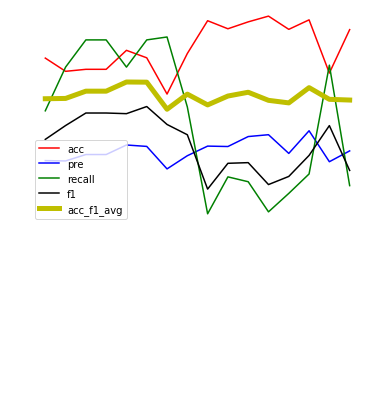

AllKNN
InstanceHardnessThreshold
SVMSMOTE
RepeatedEditedNearestNeighbours
EditedNearestNeighbours
BorderlineSMOTE
RandomUnderSampler
ADASYN
ClusterCentroids
CondensedNearestNeighbour
SMOTEENN
SMOTETomek
RandomOverSampler
SMOTE
TomekLinks
NearMiss


In [59]:
lr = RandomForestClassifier(random_state=SEED, n_estimators=10)
ImbTest(lr,trainDF_,y_train,testDF_,y_test)

In [61]:
X_train, y_train = SMOTETomek(random_state=SEED).fit_resample(trainDF_,y_train)
X_test = testDF_.copy()

In [62]:
from scipy.stats import uniform
model = LogisticRegression()
penalty = ['l1', 'l2']
C = uniform(loc=0, scale=10)
param_grid = dict(C=C, penalty=penalty)
LR_RandSearch = RandomSearch(X_train,y_train, model, param_grid)
pred_test = LR_RandSearch.BestModelPridict(X_test)
LR_BestParam = LR_RandSearch.best_param
print("LR", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("LR",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.585904 using {'C': 2.458042338249026, 'penalty': 'l2'}
LR 0.5813333333333334 0.4614065180102916
LR               precision    recall  f1-score   support

     class 0       0.78      0.57      0.66      1056
     class 1       0.37      0.61      0.46       444

    accuracy                           0.58      1500
   macro avg       0.57      0.59      0.56      1500
weighted avg       0.66      0.58      0.60      1500



In [63]:
from scipy.stats import randint
max_depth_value = [1, 2, 3]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

model = DecisionTreeClassifier()
CART_RandSearch = RandomSearch(X_train, y_train, model, param_grid)
pred_test = CART_RandSearch.BestModelPridict(X_test)
CART_BestParam = CART_RandSearch.best_param
print("CART", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("CART",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.602185 using {'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1}
CART 0.556 0.4147627416520211
CART               precision    recall  f1-score   support

     class 0       0.74      0.57      0.64      1056
     class 1       0.34      0.53      0.41       444

    accuracy                           0.56      1500
   macro avg       0.54      0.55      0.53      1500
weighted avg       0.62      0.56      0.57      1500



In [64]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [(i + 1) * 10 for i in range(5)]


param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

model = GradientBoostingClassifier()
GB_GridSearch = GridSearch(X_train, y_train,model, param_grid)
pred_test = GB_GridSearch.BestModelPridict(X_test)
GB_BestParam = GB_GridSearch.best_param
print("GBC", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("GBC",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.697729 using {'learning_rate': 0.5, 'n_estimators': 50}
GBC 0.6346666666666667 0.35377358490566035
GBC               precision    recall  f1-score   support

     class 0       0.73      0.76      0.75      1056
     class 1       0.37      0.34      0.35       444

    accuracy                           0.63      1500
   macro avg       0.55      0.55      0.55      1500
weighted avg       0.63      0.63      0.63      1500



In [65]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [(i + 1) * 10 for i in range(5)]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

model = AdaBoostClassifier()
Ad_GridSearch = GridSearch(X_train, y_train,model, param_grid)
pred_test = Ad_GridSearch.BestModelPridict(X_test)
Ad_BestParam = Ad_GridSearch.best_param
print("AD", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("AD",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.654670 using {'learning_rate': 1, 'n_estimators': 50}
AD 0.6166666666666667 0.4221105527638191
AD               precision    recall  f1-score   support

     class 0       0.75      0.68      0.71      1056
     class 1       0.38      0.47      0.42       444

    accuracy                           0.62      1500
   macro avg       0.57      0.58      0.57      1500
weighted avg       0.64      0.62      0.63      1500



In [66]:
model = KNeighborsClassifier()

neighbors = [i + 2 for i in range(50)]
param_grid = dict(n_neighbors=neighbors)

KNN_GridSearch = GridSearch(X_train, y_train, model, param_grid)
pred_test = KNN_GridSearch.BestModelPridict(X_test)
KNN_BestParam = KNN_GridSearch.best_param
print("KNN", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("KNN",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.758355 using {'n_neighbors': 2}
KNN 0.6193333333333333 0.3398843930635838
KNN               precision    recall  f1-score   support

     class 0       0.72      0.74      0.73      1056
     class 1       0.35      0.33      0.34       444

    accuracy                           0.62      1500
   macro avg       0.54      0.54      0.54      1500
weighted avg       0.61      0.62      0.62      1500



In [67]:
c_values = [0.1, 1, 5, 10, 100]
kernel_values = ['poly', 'linear', 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVC = SVC()
SVC_GridSearch = GridSearch(X_train,y_train,model_SVC,param_grid)
pred_test = SVC_GridSearch.BestModelPridict(X_test)
SVC_BestParam = SVC_GridSearch.best_param
print("SVC", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("SVC",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.690446 using {'C': 100, 'kernel': 'rbf'}
SVC 0.5886666666666667 0.44162895927601814
SVC               precision    recall  f1-score   support

     class 0       0.76      0.61      0.67      1056
     class 1       0.37      0.55      0.44       444

    accuracy                           0.59      1500
   macro avg       0.57      0.58      0.56      1500
weighted avg       0.65      0.59      0.61      1500



In [68]:
model = RandomForestClassifier()

n_estimators_value = [(i + 1) * 50 for i in range(20)]
param_grid = dict(n_estimators=n_estimators_value)


RF_GridSearch = GridSearch(X_train, y_train, model, param_grid)
pred_test = RF_GridSearch.BestModelPridict(X_test)
RF_BestParam = RF_GridSearch.best_param
print("RF", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("RF",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.779135 using {'n_estimators': 500}
RF 0.6713333333333333 0.3589076723016905
RF               precision    recall  f1-score   support

     class 0       0.74      0.82      0.78      1056
     class 1       0.42      0.31      0.36       444

    accuracy                           0.67      1500
   macro avg       0.58      0.57      0.57      1500
weighted avg       0.65      0.67      0.65      1500



In [69]:
model = ExtraTreesClassifier()

n_estimators_value = [(i + 1) * 50 for i in range(10)]
param_grid = dict(n_estimators=n_estimators_value)

ET_GridSearch = GridSearch(X_train, y_train, model, param_grid)
pred_test = ET_GridSearch.BestModelPridict(X_test)
ET_BestParam = ET_GridSearch.best_param
print("ET", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("ET",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.825835 using {'n_estimators': 350}
ET 0.6666666666666666 0.3016759776536313
ET               precision    recall  f1-score   support

     class 0       0.73      0.84      0.78      1056
     class 1       0.40      0.24      0.30       444

    accuracy                           0.67      1500
   macro avg       0.56      0.54      0.54      1500
weighted avg       0.63      0.67      0.64      1500



In [70]:
model = lgb.LGBMClassifier(boosting_type='gbdt', eval_metric='roc')
model.fit(X_train, y_train)

param_grid = {'n_estimators' : [(i + 1) * 25 for i in range(20)], }

LGB_GridSearch = GridSearch(X_train, y_train, model, param_grid)
pred_test = LGB_GridSearch.BestModelPridict(X_test)
LGB_BestParam = LGB_GridSearch.best_param
print("LGBM", accuracy_score(pred_test, y_test), f1_score(pred_test, y_test))
print("LGBM",  classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))

Best: 0.751071 using {'n_estimators': 500}
LGBM 0.6526666666666666 0.3189542483660131
LGBM               precision    recall  f1-score   support

     class 0       0.73      0.81      0.77      1056
     class 1       0.38      0.27      0.32       444

    accuracy                           0.65      1500
   macro avg       0.55      0.54      0.54      1500
weighted avg       0.62      0.65      0.63      1500



In [71]:
Models = {
    'LR'   : LogisticRegression(**LR_BestParam),
    'CRAT' : DecisionTreeClassifier(**CART_BestParam),
    'GBC'  : GradientBoostingClassifier(**GB_BestParam), 
    'ADB'  : AdaBoostClassifier(**Ad_BestParam),
    'KNN'  : KNeighborsClassifier(**KNN_BestParam),
    'SVC'  : SVC(**SVC_BestParam, probability=True), 
    'RF'   : RandomForestClassifier(**RF_BestParam),
    'ET'   : ExtraTreesClassifier(**ET_BestParam),  
    'GB'   : GaussianNB(),
    'LDA'  : LinearDiscriminantAnalysis(),
    'LGBM' : lgb.LGBMClassifier(boosting_type='gbdt', eval_metric='roc',n_estimators=500)
}

In [72]:
P = {}
for model_name, model in Models.items(): 
    model.fit(X_train, y_train)
    
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    P[model_name] = pred_test
    predAcc = accuracy_score(pred_test, y_test)
    trainAcc = accuracy_score(pred_train, y_train)
    predF1 = f1_score(pred_test, y_test)
    print(model_name)
    print(classification_report(y_test, pred_test, target_names=['class 0', 'class 1']))
P = pd.DataFrame(P)

LR
              precision    recall  f1-score   support

     class 0       0.78      0.57      0.66      1056
     class 1       0.37      0.61      0.46       444

    accuracy                           0.58      1500
   macro avg       0.57      0.59      0.56      1500
weighted avg       0.66      0.58      0.60      1500

CRAT
              precision    recall  f1-score   support

     class 0       0.73      0.43      0.54      1056
     class 1       0.32      0.63      0.42       444

    accuracy                           0.49      1500
   macro avg       0.53      0.53      0.48      1500
weighted avg       0.61      0.49      0.51      1500

GBC
              precision    recall  f1-score   support

     class 0       0.73      0.76      0.75      1056
     class 1       0.37      0.34      0.35       444

    accuracy                           0.64      1500
   macro avg       0.55      0.55      0.55      1500
weighted avg       0.63      0.64      0.63      1500

ADB
   

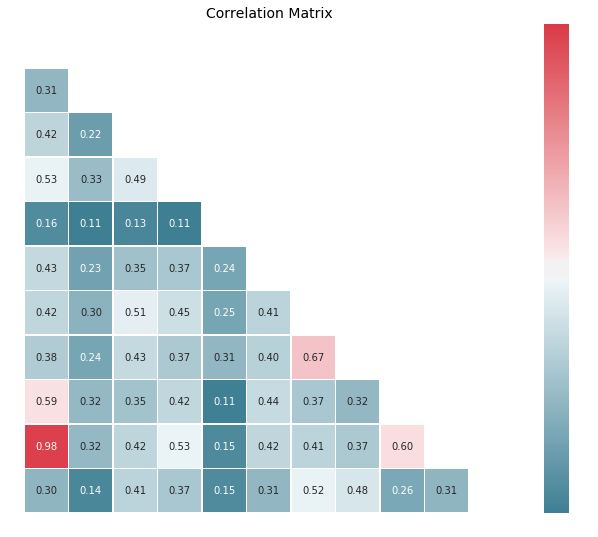

In [73]:
from mlens.visualization import corrmat

with plt.rc_context({'axes.edgecolor':'white',
                        'xtick.color':'white',
                        'ytick.color':'white',}):
    corrmat(P.corr(), inflate=False)

In [74]:
modelDic2 = {
  modelName : Models[modelName]  for modelName in ['ET', 'RF'] # 'KNN'
}

In [75]:
from sklearn.ensemble import VotingClassifier

kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
ensemble = VotingClassifier([(k, v) for k, v in modelDic2.items()], voting='hard')
results = cross_val_score(ensemble, X_train, y_train, cv=kfold)
print('Accuracy on train: ',results.mean())
ensemble_model = ensemble.fit(X_train, y_train)
pred = ensemble_model.predict(X_test)
print('Accuracy on test:' , accuracy_score(pred, y_test), precision_score(pred, y_test))
print("Total : ", classification_report(y_test, pred, target_names=['class 0', 'class 1']))

Accuracy on train:  0.7932733504712939
Accuracy on test: 0.6793333333333333 0.20045045045045046
Total :                precision    recall  f1-score   support

     class 0       0.72      0.88      0.79      1056
     class 1       0.41      0.20      0.27       444

    accuracy                           0.68      1500
   macro avg       0.57      0.54      0.53      1500
weighted avg       0.63      0.68      0.64      1500



In [76]:
test = pd.read_csv('data/test.csv',encoding='euc-kr')
train = pd.read_csv('data/train.csv',encoding='euc-kr')
train = dataPrep(train)
test = dataPrep(test)

In [77]:
test.replace(train.groupby('주구매코너').mean()['morning'].to_dict(), inplace=True)
test = test.rename(columns={'주구매코너' : 'MostCorner',
              '주말방문비율'  : 'WeekendEnter',
              '평균할부개월수': 'meanInstallment',
              '수입상품_구매비율' : 'Import_Ratio'})

test.columns

Index(['총구매액', '구매건수', '평균구매가격', 'meanInstallment', '구매브랜드종류', '내점일수',
       'Import_Ratio', 'WeekendEnter', '가을_구매건수', '겨울_구매건수', '봄_구매건수',
       '여름_구매건수', '아침_구매건수', '저녁_구매건수', '점심_구매건수', 'MostCorner',
       'totalBuyPrice', 'meanBuyPrice', 'brandNumRatio', 'meanBuyNum',
       'meanBuyWhenCome', 'spring', 'summer', 'fall', 'winter', 'morning',
       'night', 'lunch', 'log_totalBuyPrice', 'log_meanBuyPrice'],
      dtype='object')

In [78]:
testDF = PCA_FACTOR(test[xCol], factor_dict_0, PCA_LIST=pcaList_0, num=0)

In [79]:
test_pred = ensemble_model.predict(testDF)

In [80]:
res = pd.DataFrame({'gender' : test_pred})
res.to_csv('data/나찬주_이의정_이자경-gender.csv')

In [81]:
res.sum()

gender    2008
dtype: int64